In [90]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

In [184]:
class EchoStateNetwork:
    def __init__(self, nr_reservoir, spectral_radius, input_scaling, reg_coefficient, seed=42):
        """
        Initialize the Echo State Network (ESN) with given parameters.
        """
        self.nr_reservoir = nr_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.reg_coefficient = reg_coefficient
        self.Nu = 1

        np.random.seed(seed)
        self.Win = np.random.uniform(-1, 1, (nr_reservoir, self.Nu + 1)) * self.input_scaling
        self.W = np.random.uniform(-1, 1, (nr_reservoir, nr_reservoir))
        rhoW = max(abs(linalg.eig(self.W)[0]))
        self.W *= spectral_radius / rhoW

    def train(self, data, first_steps, train_length):
        """
        Train the Echo State Network (ESN).
        """
        X = np.zeros((1 + self.Nu + self.nr_reservoir, train_length - first_steps))
        Yt = data[None, first_steps + 1:train_length + 1]

        self.states = np.zeros((self.nr_reservoir, 1))
        for t in range(train_length):
            u = data[t]
            self.states = np.tanh(np.dot(self.Win, np.vstack((1, u))) + np.dot(self.W, self.states))
            if t >= first_steps:
                X[:, t - first_steps] = np.vstack((1, u, self.states))[:, 0]

        ridge = Ridge(alpha=self.reg_coefficient, fit_intercept=False)
        ridge.fit(X.T, Yt.flatten())
        self.ridge = ridge
        self.Wout = ridge.coef_

    def predict(self, data, test_length):
        """
        Predict using the trained Echo State Network (ESN).
        """
        Y = np.zeros((1, test_length))
        x = self.states.copy()
        u = data[len(data)-test_length]
        for t in range(test_length):
            x = np.tanh(np.dot(self.Win, np.vstack((1, u))) + np.dot(self.W, x))
            y = np.dot(self.Wout, np.vstack((1, u, x)))
            Y[:, t] = y
            u = y

        self.mse = sum(np.square(data[len(data)-test_length:len(data)] - Y[0, :])) / test_length
        return Y

In [186]:
def sinusoidal_signal_sim():
    train_length = 3000
    test_length = 1000
    nr_reservoir = 1000
    spectral_radius = 0.8
    reg_coefficient = 1e-8
    input_scaling = 0.2

    n = np.arange(1, 4001)
    data = 0.5 * np.sin(n / 4)

    # Initialize and train ESN
    esn = EchoStateNetwork(nr_reservoir=nr_reservoir, spectral_radius=spectral_radius, input_scaling=input_scaling, reg_coefficient=reg_coefficient)
    esn.train(data=data, first_steps=1000, train_length=train_length)

    # Predict
    predictions = esn.predict(data, test_length)

    plt.figure()
    plt.plot(data[train_length:train_length + test_length], label="Ground truth")
    plt.plot(predictions.flatten(), label="ESN prediction")
    plt.legend()
    plt.title('ESN Model Prediction vs Ground Truth for Sinusoidal Signal')
    plt.show()

    print(f"Mean Squared Error for the sinusoidal signal: {esn.mse}")

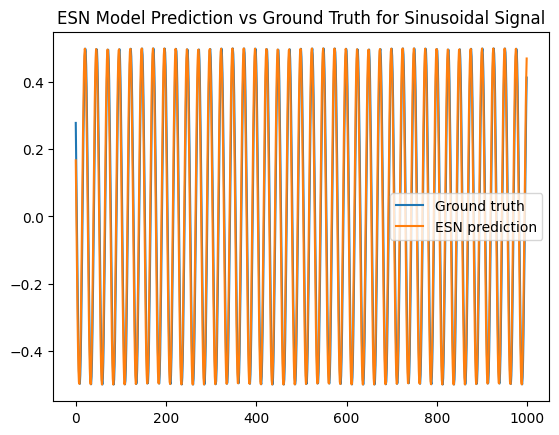

Mean Squared Error for the sinusoidal signal: 0.007796469455762339


In [187]:
sinusoidal_signal_sim()

In [143]:
def mackey_glass(tau, length):
    betta=0.2
    gamma = 0.1 
    a=10
    delay=100 # will cut these initial steps
    
    y=np.random.rand(tau) # random intial values between 0 and 1
    # Euler's method to solve the differential equation
    for t in range(tau-1, length+delay+tau-1):
        current= y[t] + ( betta * y[t-(tau-1)]   / ( 1 + np.power(y[t-(tau-1)], a) 
)  ) - gamma*y[t]   
        y=np.append(y, current)
    
    y=y-1 # get rid of mean
    y=np.tanh(y) # squeze with tanh    
    
    return y[tau+delay:length+delay+tau] # return the last length elements

In [144]:
def mackey_glass_sim():
    train_length = 3000
    test_length = 1000
    nr_reservoir = 1000
    spectral_radius = 0.8
    reg_coefficient = 1e-8
    input_scaling = 0.2

    # Generate series
    data = mackey_glass(tau=17, length=4000)

    esn = EchoStateNetwork(nr_reservoir=nr_reservoir, spectral_radius=spectral_radius, input_scaling=input_scaling, reg_coefficient=reg_coefficient)
    esn.train(data, first_steps=1000, train_length=train_length)

    # Predict
    predictions = esn.predict(data, test_length)

    # Plot result
    plt.figure()
    plt.plot(data[train_length:train_length+test_length], label="Ground truth")
    plt.plot(predictions.flatten(), label="ESN prediction")
    plt.legend()
    plt.title('ESN Model Prediction vs Ground Truth for Mackey-Glass Series')
    plt.show()

    print(f"Mean Squared Error for the Mackey-Glass series: {esn.mse}")

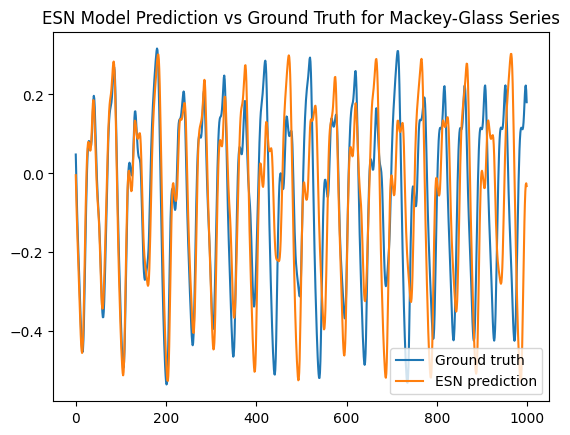

Mean Squared Error for the Mackey-Glass series: 0.032146000504688854


In [178]:
mackey_glass_sim()

In [207]:
class EchoStateNetwork2D:
    def __init__(self, nr_reservoir, spectral_radius, input_scaling, reg_coefficient, Nu, seed=42):
        """
        Initialize the Echo State Network (ESN) with given parameters.
        """
        self.nr_reservoir = nr_reservoir
        self.spectral_radius = spectral_radius
        self.input_scaling = input_scaling
        self.reg_coefficient = reg_coefficient
        self.Nu = Nu

        np.random.seed(seed)
        self.Win = np.random.uniform(-1, 1, (nr_reservoir, self.Nu + 1)) * self.input_scaling
        self.W = np.random.rand(self.nr_reservoir, self.nr_reservoir)
        self.W[np.random.rand(*self.W.shape) > 0.1] = 0
        rhoW = max(abs(linalg.eig(self.W)[0]))
        self.W *= spectral_radius / rhoW

    def train(self, x_data, y_train_onehot):
        """
        Train the Echo State Network (ESN).
        """

        X_train_with_bias = np.hstack((np.ones((x_data.shape[0], 1)), x_data))
        states = np.zeros((x_data.shape[0], self.nr_reservoir))
        self.states = np.zeros((self.nr_reservoir,))
        for i in range(X_train_with_bias.shape[0]):
            u = X_train_with_bias[i]
            self.states = np.tanh(np.dot(self.Win, u) + np.dot(self.W, self.states))
            states[i] = self.states

        ridge = Ridge(alpha=self.reg_coefficient, fit_intercept=False)
        ridge.fit(states, y_train_onehot)
        self.ridge = ridge
        self.Wout = ridge.coef_

    def predict(self, X_test, encoder):
        """
        Predict using the trained Echo State Network (ESN).
        """
        X_test_with_bias = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        states = np.zeros((X_test.shape[0], self.nr_reservoir))
        x = np.zeros((self.nr_reservoir,))
        for i in range(X_test_with_bias.shape[0]):
            u = X_test_with_bias[i]
            x = np.tanh(np.dot(self.Win, u) + np.dot(self.W, x))
            states[i] = x
        y_pred_onehot = self.ridge.predict(states)
        y_pred = encoder.inverse_transform(y_pred_onehot)
        return y_pred

    def get_accuracy(self, X_test, y_test, encoder):
        y_pred = self.predict(X_test, encoder)
        return accuracy_score(y_test, y_pred)

In [208]:
def read_data(file_path):
    data = np.loadtxt(file_path)
    X = data[:, 1:]  # features
    y = data[:, 0].astype(int)  # labels
    return X, y


X_train, y_train = read_data('dataset/SwedishLeaf_TRAIN.txt')
X_test, y_test = read_data('dataset/SwedishLeaf_TEST.txt')
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

encoder = OneHotEncoder(sparse=False, categories='auto')
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

n_reservoir = 800

accuracies = []
for _ in range(10):
    esn = EchoStateNetwork2D(nr_reservoir=n_reservoir, spectral_radius=0.99, input_scaling=0.25, reg_coefficient=1.0, Nu=X_train.shape[1])
    esn.train(X_train, y_train_onehot)
    accuracy = esn.get_accuracy(X_test, y_test, encoder)
    accuracies.append(accuracy)

average_accuracy = np.mean(accuracies)
print(f"Average classification accuracy over 10 runs: {average_accuracy:.2f}")

Average classification accuracy over 10 runs: 0.76
